In [1]:
from __future__ import print_function, division
import pandas as pd
import os
import requests
import shapely
import json
import io
from fiona.crs import from_epsg
import scipy as sp
from scipy import stats
import urllib
import requests
import geopandas as gpd
import pylab as pl
import choropleth as cp #using FBB's choropleth function
from statsmodels.graphics.api import abline_plot
import matplotlib.gridspec as gridspec

%pylab inline


from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

Populating the interactive namespace from numpy and matplotlib


## to load, move, and unzip data, uncomment code is cells below ##


In [2]:
#!curl -O https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD

In [3]:
#!mv rows.csv?accessType=DOWNLOAD $PUIDATA

In [4]:
#!curl -O https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_18v1.zip

In [5]:
# !unzip mn_mappluto_18v1.zip -d $PUIDATA

## Reading in and examining the data

In [6]:
nrg = pd.read_csv(os.getenv('PUIDATA') + '/rows.csv?accessType=DOWNLOAD')

In [7]:
bsize = gpd.GeoDataFrame.from_file(os.getenv('PUIDATA') + '/MNMapPLUTO.shp')

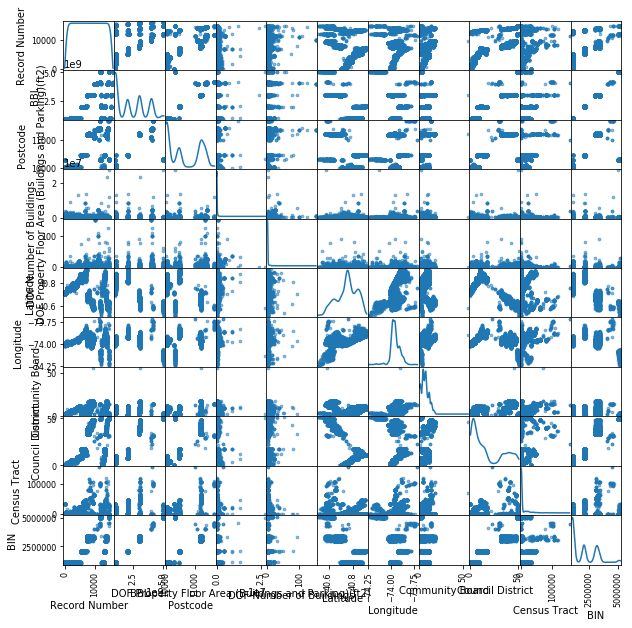

In [8]:
sfig = pd.scatter_matrix(nrg, s=30, figsize=(10, 10), diagonal='kde')

Figure 1: Energy data from Local Law 84 in 2013. This plot shows correlations between variables that can be plotted, i.e. numeric values. Since there are many columns we're not exploring for this homework, many of the plots are not useful. 

In [9]:
nrg = nrg[['BBL', 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)']]
nrg.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,1.000410e+09,NaN,918919
1,4.021460e+09,NaN,NaN
2,2.027620e+09,NaN,64200
3,1.006700e+09,NaN,NaN
4,2.048300e+09,NaN,50000


In [10]:
bsize = bsize[['UnitsRes', 'UnitsTotal', 'YearBuilt', 'BBL', 'geometry']]
bsize.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,geometry
0,16,18,1920,1.015450e+09,"POLYGON ((997277.2344360352 221816.0936279297,..."
1,50,50,1914,1.007238e+09,"POLYGON ((984164.5626220703 211846.0704345703,..."
2,10,10,1910,1.016800e+09,"POLYGON ((1000742.195800781 227910.6640014648,..."
3,29,32,1928,1.013850e+09,"POLYGON ((994007.6885986328 219880.4284057617,..."
4,26,26,1900,1.011970e+09,"POLYGON ((992273.6849975586 224863.4904174805,..."


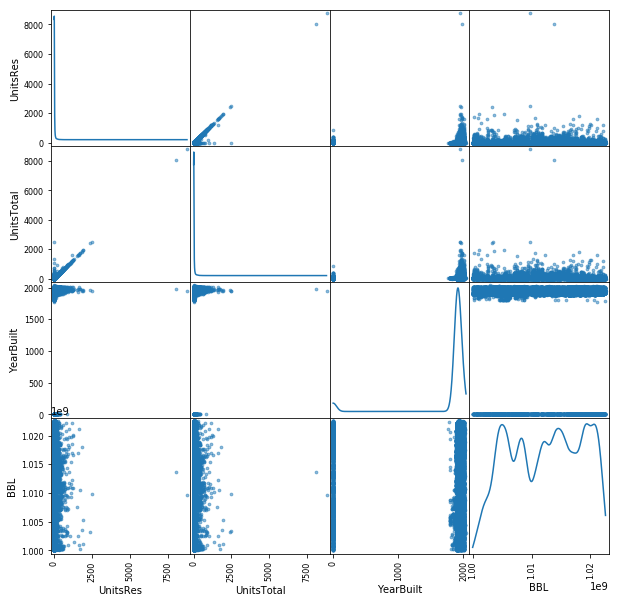

In [11]:
sfig = pd.scatter_matrix(bsize, s=30, figsize=(10,10), diagonal='kde')

Figure 2: A scatter matrix of energy data from Local Law 84 in 2013 showing correlations between four variables: residential units, total units (residential and non-residential), year built, and BBL (borough, tax block, and lot). The only variables that seem to have any relationship are residential units and total units, which does not tell us much about our data. 

## converting  the relevant columns to numeric values and throwing away spurious entries

In [12]:
# nrg : column 2 and column 3 are objects, first is float
# bsize : only object is geometry, yearbuilt is int

In [13]:
nrg['Reported Property Floor Area (Building(s)) (ft²)'] = pd.to_numeric(nrg['Reported Property Floor Area \
(Building(s)) (ft²)'], errors='coerce')

In [14]:
nrg['Site EUI(kBtu/ft2)'] = pd.to_numeric(nrg['Site EUI(kBtu/ft2)'], errors='coerce')

In [15]:
nrg['Site EUI(kBtu/ft2)'].astype(float)[:10]

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
Name: Site EUI(kBtu/ft2), dtype: float64

In [16]:
# checking that the conversion worked (Fed's instructions): 
print ("number of missing energy observations:", np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum())

number of missing energy observations: 4623


In [17]:
# checking that the conversion worked (Fed's instructions):
print ("fraction of missing energy observations: %.2f"%(np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum() /
      len(nrg['Site EUI(kBtu/ft2)'])))

fraction of missing energy observations: 0.29


## merge the 2 datasets
 I can merge the dataframes on NYC Borough, Block, and Lot: BBL

In [18]:
# creating geo df for plotting
bblnrgdataGPD = pd.merge(bsize, nrg, on='BBL')
bblnrgdataGPD = gpd.GeoDataFrame(bblnrgdataGPD)

In [19]:
# creating df to analysis
bblnrgdata = pd.merge(bsize, nrg, on='BBL')
del bblnrgdata['geometry']
bblnrgdata.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,50,50,1914,1.007238e+09,68.7,95844.0
1,29,32,1928,1.013850e+09,87.4,206989.0
2,72,72,1923,1.021740e+09,140.4,52920.0
3,107,108,1931,1.008830e+09,96.5,98359.0
4,134,138,1910,1.008570e+09,36.4,154000.0


# Plot the data as a choropleth for the 2 quantities of interest: number of units and energy consumed energy

In [20]:
# need to convert lat/long to meters or feet - just how this works 
bblnrgdataGPD.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
shape = bblnrgdataGPD.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 

In [21]:
# need to create new columns for log of units and log of energy consumed

bblnrgdataGPD['logunits'] = np.log(bblnrgdata['UnitsTotal'] + 1)
bblnrgdataGPD['logenergy'] = np.log(bblnrgdata['Site EUI(kBtu/ft2)'] + 1)

In [22]:
bblnrgdataGPD.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,geometry,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),logunits,logenergy
0,50,50,1914,1.007238e+09,"POLYGON ((984164.5626220703 211846.0704345703,...",68.7,95844.0,3.931826,4.244200
1,29,32,1928,1.013850e+09,"POLYGON ((994007.6885986328 219880.4284057617,...",87.4,206989.0,3.496508,4.481872
2,72,72,1923,1.021740e+09,"POLYGON ((1004080.155029297 252930.9956054688,...",140.4,52920.0,4.290459,4.951593
3,107,108,1931,1.008830e+09,"POLYGON ((989337.639831543 209686.7838134766, ...",96.5,98359.0,4.691348,4.579852
4,134,138,1910,1.008570e+09,"POLYGON ((988035.3540039062 210290.9854125977,...",36.4,154000.0,4.934474,3.621671


(<matplotlib.figure.Figure at 0x7fa93a20f550>,
 <matplotlib.colorbar.Colorbar at 0x7fa93a850e48>)

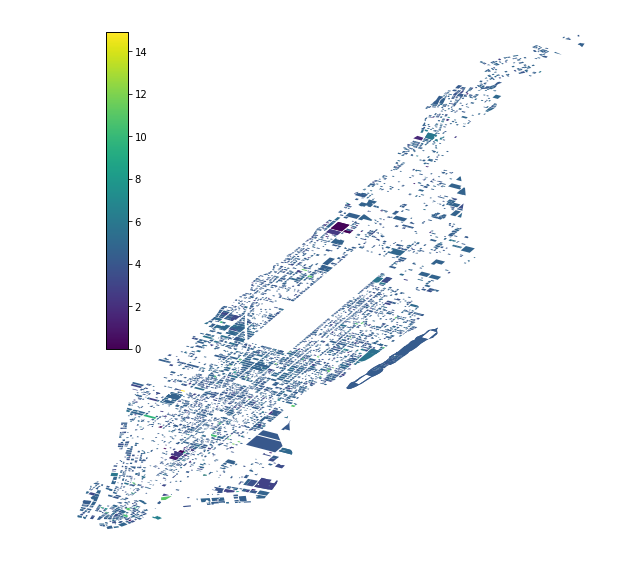

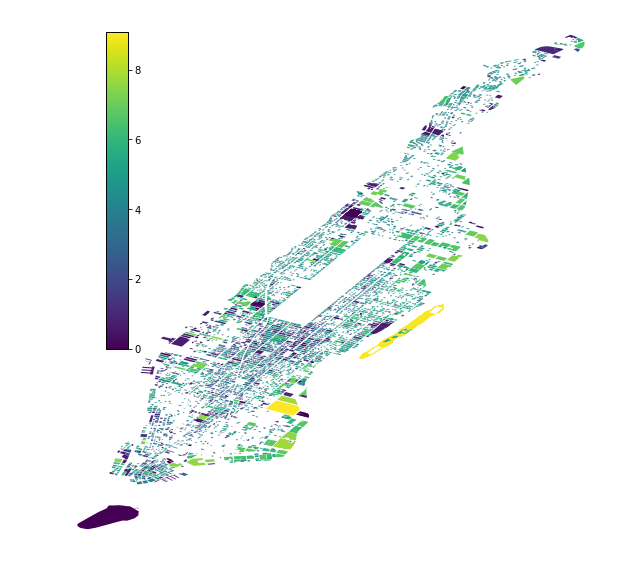

In [23]:
fig = plt.figure(figsize = (12,10))
cp.choroplethNYC(bblnrgdataGPD, column='logenergy', cmap='viridis', lw=2)
cp.choroplethNYC(bblnrgdataGPD, column='logunits', cmap='viridis', lw=2)

Figure 3 and 4: Two maps of Manhattan. The first shows the log total of energy consumed per BBL (Borough, Block and Lot). There seems to be a lot of missing information/datapoints on this plot, with the obvious gap of buildings in Central Park. The second shows the log total of units per BBL. There are two pockets of high numbers of units - one seems to be Roosevelt Island, which does not make much sense, and the other may be Stuy Town, a large block of privately owned land with a few apartment complexes. 

# feature engineering
the question was not if larger buildings consume more energy, its if occupancy increases consumption, so we want to model *total energy* with *total units*.
Create a total energy column from the columns you have.
Plot a column vs the other. You will be unable to see most of the points (as in the plot below). Make another plot "zooming in" to remove some outliers from the view and see if this reveals some patterns.

In [24]:
# creating total energy column by multiplying area by energy/area to get total energy per building

bblnrgdata['total_energy'] = bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'] *\
                            bblnrgdata['Site EUI(kBtu/ft2)']

Text(0,0.5,'Total Units per Building')

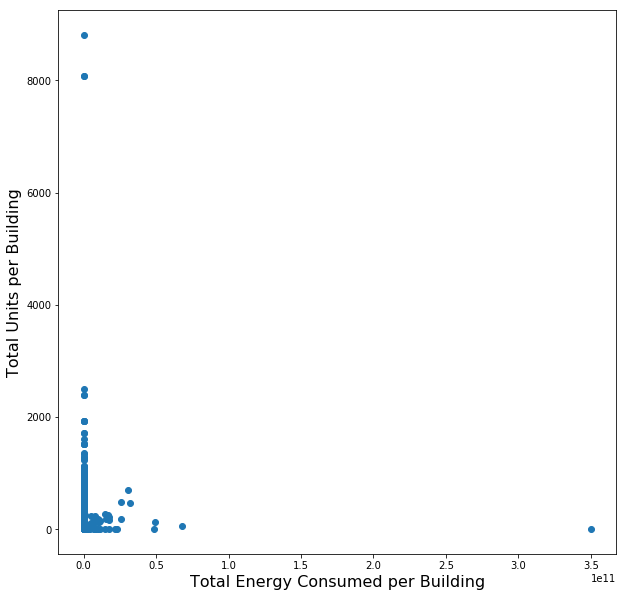

In [25]:
# not zoomed in plot 
fig = plt.figure(figsize = (10,10))
plt.scatter(bblnrgdata['total_energy'], bblnrgdata['UnitsTotal'])
plt.xlabel('Total Energy Consumed per Building', fontsize=16)
plt.ylabel('Total Units per Building', fontsize=16)

Figure 5: Scatterplot of total units per building and total energy consumed per building. This plot has a lot of white space and the data are bunched into one corner, not helping us identify any trends, but there are 3 points that are far outside the main cluster of data. All three seems to be errors: the bottom right point seems to be a 0 unit building consuming a massive amount of energy, which does not make sense. The two in the upper left corner apparently have 8000 units or more in their respective buildings, but somehow consume no energy (i.e. not possible). The following graphs zooms in a bit more to let us examine the data a bit better. 

(1, 100000000000.0)

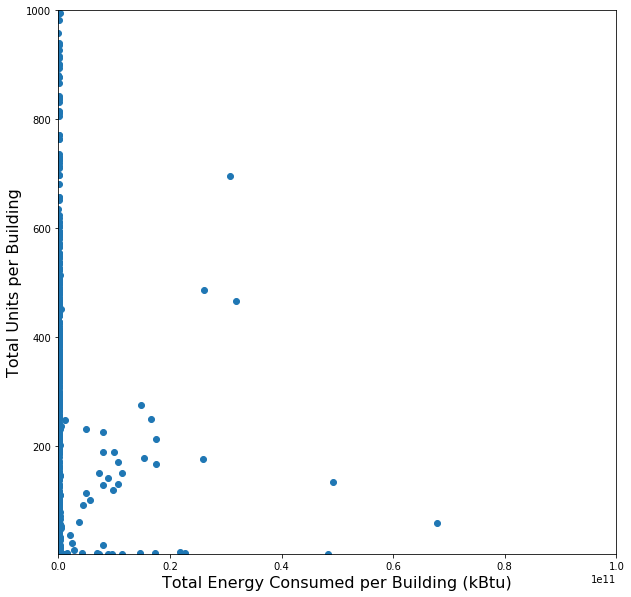

In [26]:
# zoomed in plot

fig = plt.figure(figsize = (10,10))
plt.scatter(bblnrgdata['total_energy'], bblnrgdata['UnitsTotal'])
plt.xlabel('Total Energy Consumed per Building (kBtu)', fontsize=16)
plt.ylabel('Total Units per Building', fontsize=16)
plt.ylim(1, 1000)
plt.xlim(1, 1e11)

Figure 6: Plot of total units per building in Manhattan and their total energy use. After fixing the x and y scale to "zoom in", we see a general positive relationship emerge between total energy consumed and total units per building. As illustrated in the plot above as well, there are a lot of 0 values. 

# Plot both NRG vs Units total and Units total vs NRG, both in log space

Surely there is a right way to think about which one is the independent and the dependent variable in this problem: do we think energy consumption causes occupancy or occupancy causes consumption?

You are going to have to limit the axis values or you will not see anything: 

    energy between (1000,1e10)

    units between (1,1000)

You can cut the axis to visualize the data like this, **but you will need to cut the data to remove datapoint outside of this range when you model to get a good model.**

to visualize the data in log scale you can use the dataframe plotting method with the argument 

    loglog=True



In [27]:
# making bbldata into regular data frame
bblnrgdata = pd.DataFrame(bblnrgdata)

(1, 1000)

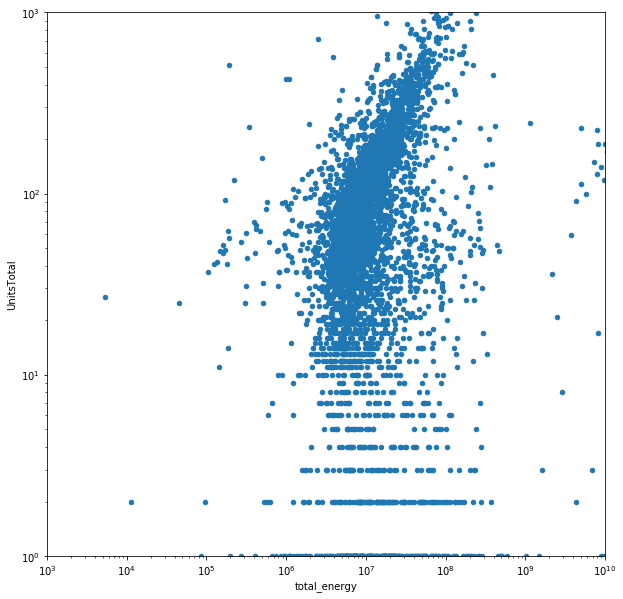

In [28]:
# units against energy 

ax = bblnrgdata.plot(x='total_energy', y='UnitsTotal', loglog=True, kind='scatter', figsize=(10,10))
ax.set_xlim(1000, 1e10)
ax.set_ylim(1, 1000)


Figure 7: Total units against total energy in log space. From this representation, there are a lot of buildings with different ranges of units per building consuming similar amounts of energy, which does not seem right. Let's versus the plot and see what happens!

(1000, 10000000000.0)

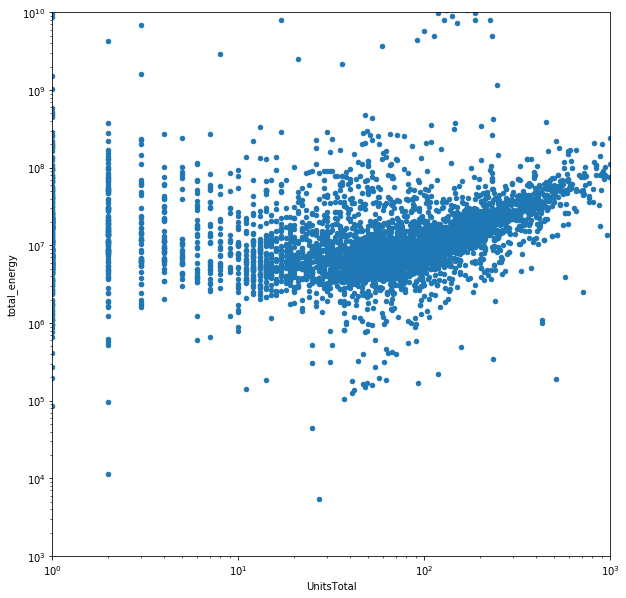

In [29]:
# energy against units  

ax = bblnrgdata.plot(x='UnitsTotal', y='total_energy', loglog=True, kind='scatter', figsize=(10,10))
ax.set_xlim(1, 1000)
ax.set_ylim(1000, 1e10)

Figure 8: Total energy vs total units in log space. The representation makes a bit more sense than the plot above - as the number of units per building increases, we see a general upward trend of energy use. 

## Model NRG as a linear function of number of units in the building 
Ciertainly there is a right way to think about this: which is the *independent* and the *dependent* variable? which do we think causes which? do units "cause"energy consumption or vice versa? please answer below

**answer** Energy used is a function of how many units are in a building - you cannot have energy without units using it! 

However, indulge me and try both models: models (nrg vs units total & units total vs nrg). 

- create the models with statsmodels
- print the model summary
- plot the data and the fit
- Check and comment on how the following model diagnostics change: 
        R^2 and LogLikelihood
        
(remember to use only the data in the appropriate range, see the previous step)

# need to cut the data before modeling, getting nans

energy between (1000,1e10)

units between (1,1000)


In [30]:
# reducing data set based on parameters provided by FBB
bblcut = bblnrgdata[(bblnrgdata.total_energy > 1000) & (bblnrgdata.UnitsTotal > 1) & (bblnrgdata.total_energy < 1e10) &
        (bblnrgdata.UnitsTotal < 1000)]

In [31]:
# sorting values based on exogenous value, guidance given on slack channel by FBB
bblcut.sort_values(by='UnitsTotal', inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [32]:
bblcut['log_energy'] = np.log10(bblcut['total_energy'] + 1)
bblcut['log_units'] = np.log10(bblcut['UnitsTotal'] + 1)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### Energy against Units


In [33]:
# need to add constant otherwise line does not show up 
exog = sm.add_constant(bblcut.log_units)
model_r = sm.OLS(bblcut.log_energy, exog, missing='drop').fit()

In [34]:
print(model_r.summary())

                            OLS Regression Results                            
Dep. Variable:             log_energy   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     296.7
Date:                Fri, 30 Nov 2018   Prob (F-statistic):           1.69e-64
Time:                        18:05:37   Log-Likelihood:                -2839.5
No. Observations:                4624   AIC:                             5683.
Df Residuals:                    4622   BIC:                             5696.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.6192      0.025    265.249      0.0

Text(0.5,1,'Energy Use by Number of Units in Buildings')

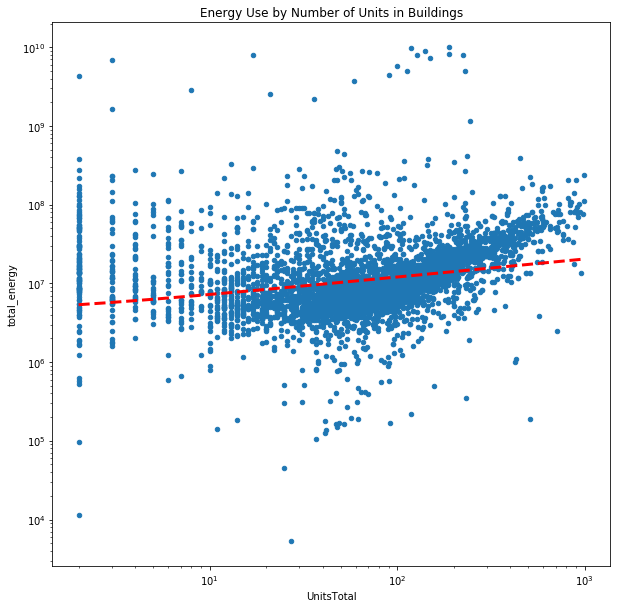

In [35]:
# plotting fitted line with scatter plot above

pl.figure()
bblcut.plot(x='UnitsTotal', y='total_energy', kind='scatter', loglog=True, figsize=(10,10))
pl.plot(bblcut.UnitsTotal, 10**model_r.predict(exog), '--', label='fitted line', c='r', lw=3)
pl.title('Energy Use by Number of Units in Buildings')

Figure 9: Fitting a linear model to the energy and units data. Not the worst fit in the world. 

### Units vs Energy

In [36]:
# need to add constant otherwise line does not show up 
exog = sm.add_constant(bblcut.log_energy)
model_w = sm.OLS(bblcut.log_units, exog, missing='drop').fit()

In [37]:
print(model_w.summary())

                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     296.7
Date:                Fri, 30 Nov 2018   Prob (F-statistic):           1.69e-64
Time:                        18:05:38   Log-Likelihood:                -3141.3
No. Observations:                4624   AIC:                             6287.
Df Residuals:                    4622   BIC:                             6300.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0420      0.107     -0.391      0.6

Text(0.5,1,'Energy Use by Number of Units in Buildings')

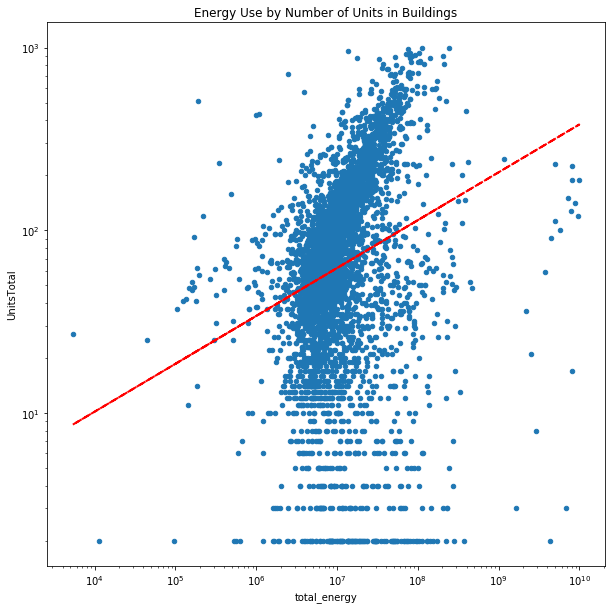

In [38]:
# plotting fitted line with scatter plot above

pl.figure()
bblcut.plot(x='total_energy', y='UnitsTotal', kind='scatter', loglog=True, figsize=(10,10))
pl.plot(bblcut.total_energy, 10**model_w.predict(exog), '--', label='fitted line', c='r', lw=2)
pl.title('Energy Use by Number of Units in Buildings')

Figure 10: Fitting a linear model to the energy and units data. Plotting the data does not make sense this way (you need a building with units to have energy consumption, so having energy as the independent variable does not make sense) and our line does not provide a great fit (at least visually) either. 

# Second degree polynomial fit

model the data with a slightly more complex model: 
    
    y = ax*x + bx + c, 

instead of 
        
    y = bx + c
    
**make sure you print the summary and plot the data and the model**



In [39]:
model_best = smf.ols(formula='log_energy ~ I(log_units**2) + log_units', data=bblcut).fit()
print(model_best.summary())

                            OLS Regression Results                            
Dep. Variable:             log_energy   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     584.5
Date:                Fri, 30 Nov 2018   Prob (F-statistic):          5.08e-227
Time:                        18:05:39   Log-Likelihood:                -2462.0
No. Observations:                4624   AIC:                             4930.
Df Residuals:                    4621   BIC:                             4949.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept             7.8501      0.04

Text(0.5,1,'Energy Use by Number of Units in Buildings')

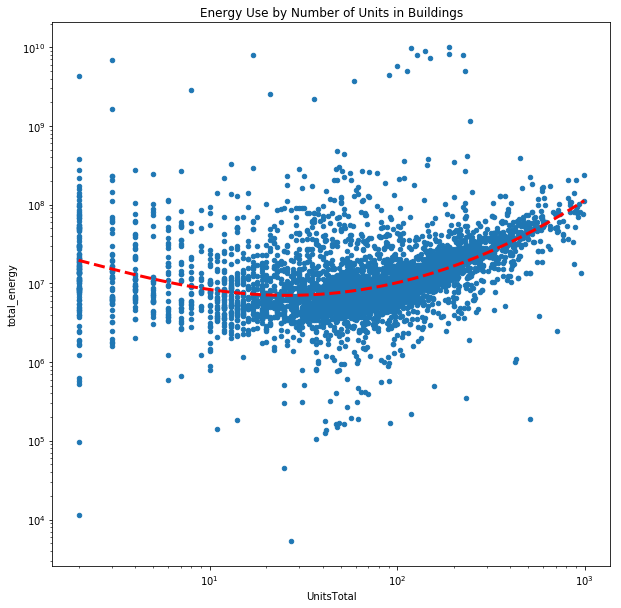

In [40]:
# plotting fitted line with scatter plot above

pl.figure()
bblcut.plot(x='UnitsTotal', y='total_energy', kind='scatter', loglog=True, figsize=(10,10))
pl.plot(bblcut.UnitsTotal, 10**model_best.predict(bblcut), '--', label='fitted line', c='r', lw=3)
pl.title('Energy Use by Number of Units in Buildings')

Figure 11: Fitting a quadratic model to our energy and units data. From the regression results (R2) and fit of the line, we have improved our model considerably from the earlier restricted model. 

# calculate the chi square and likelihood of your model

In [53]:
# defining chi square 
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passed all errors are set to 1
    '''
    
    if errors is not None: 
        y1 = (((data-model.predict())**2)/errors**2).sum()
        return y1
    else:
        y2 = ((data-model.predict())**2).sum()
        return y2

In [54]:
# running chi squared test

chi2(bblcut['log_energy'], model_r)

924.55350508695142

## Define and calculate errors

Assume Poisson statistics and calculate the errors accordingly. Remember that you have used 2 quantities combined linearly to calculate the energy (your *dependent* variable) , so the errors combine in quadrature!

    Total Error = sqrt(error1^2 + error2^2)
    
Your *independent* variable has uncertainty also! assume it is also Poissonian

** propagation of errors on the log:**
https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Linear_combinations

$f=a\log _{10}(A)$

$\sigma _{f}\approx \left(a{\frac {\sigma _{A}}{A\ln(10)}}\right)$

In [43]:
## Assume that there is error in the reported energy. 
## but that is the product of two measured qusntities, each of which will have errors. 
## The minimum error is the squareroot of the value

#errors on the measured quantities
bblcut['errorsnrg'] = np.sqrt((bblcut['Reported Property Floor Area (Building(s)) (ft²)']**2) +\
                    (bblcut['Site EUI(kBtu/ft2)']**2))


# better WOULD BE to calculate each error and add in quadrature: sqrt(1/A + 1/B) which becomes
#errorsnrg = np.sqrt(1.0 / bblnrgdataCut['Reported Property Floor Area'] + 1.0 / bblnrgdataCut['Site EUI(kBtu/ft2)'])
#but this leads to insane error values (insanely small)

## Assume count statistics in the number of units as well
bblcut['errorsunits'] = np.sqrt(bblcut.UnitsTotal)



/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [44]:
# extra errors in log? 

log_energy_errors = np.abs(bblcut.errorsnrg / bblcut.total_energy / np.log(10))
log_units_errors = np.abs(bblcut.errorsunits / bblcut.UnitsTotal / np.log(10))

bblcut['errorsnrg'] = log_energy_errors
bblcut['errorsunits'] = log_units_errors

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Make 3 plots: one with x errors, one with y errors, one with x and y errors. 

with pylab you can do it with pl.errorbar(x, y, xerr=xerror, yerr=yerror)

The largest error bar is for


,UnitsRes,UnitsTotal,YearBuilt,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),total_energy,log_energy,log_units,errorsnrg,errorsunits
3313,27,27,1909,1.019900e+09,0.1,53440.0,5344.0,3.727948,1.447158,4.342945,0.08358


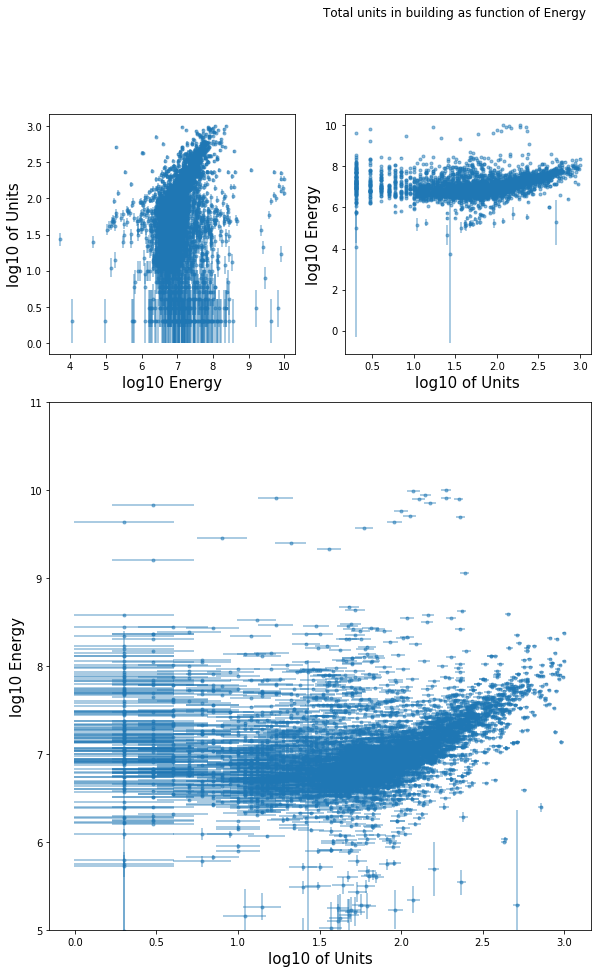

In [45]:
#I could also include errors for number of units
fig2 = plt.figure(figsize=(15,15))

gs1 = gridspec.GridSpec(3, 3)
gs1.update(left=0.68, right=0.68, wspace=0.2)


ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1)
ax1.errorbar(np.log10(bblcut.total_energy), np.log10(bblcut.UnitsTotal), 
            yerr=bblcut.errorsunits, fmt='.',
            alpha=0.5)
ax1.set_xlabel("log10 Energy", fontsize=15)
ax1.set_ylabel("log10 of Units", fontsize=15)
pl.suptitle("Total units in building as function of Energy")


ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=1)
ax2.errorbar(np.log10(bblcut.UnitsTotal), np.log10(bblcut.total_energy), yerr=bblcut.errorsnrg, fmt='.', alpha=0.5)
ax2.set_xlabel("log10 of Units", fontsize=15)
ax2.set_ylabel("log10 Energy", fontsize=15)

ax4 = plt.subplot2grid((3, 3), (1, 0), colspan=2, rowspan=2)
ax4.errorbar(np.log10(bblcut.UnitsTotal), np.log10(bblcut.total_energy), 
            yerr=bblcut.errorsnrg,
           xerr=bblcut.errorsunits, alpha=0.5, fmt='.')
ax4.set_xlabel("log10 of Units", fontsize=15)
ax4.set_ylabel("log10 Energy", fontsize=15)
ax4.set_ylim(5,11)

print ("The largest error bar is for")
bblcut[bblcut.errorsnrg == bblcut.errorsnrg.max()]

Figure 12: Scatterplots with energy versus units, plotted with error bars. 

## Add the errors and calculate the chi square

### calculate the degrees of freedom of this model

In [46]:
#degrees of freedom: number of observations - number of model parameters
# note: these are reported as dof of the residuals in the statsmodels fit summary
# from model2 summary: df are 4621

dof = float(len(bblcut) - len(model_r.params))
print ("degrees of freedom:" , dof)

degrees of freedom: 4622.0


In [47]:
# print("Units vs Energy residuals (no errors include): " \
#       (chi2(np.log10(bblcut.UnitsTotal), model_r.predict(), 
#             errors = None) / dof))

print("Units vs Energy chi square per DOF w independent variable error only: %.2f"%\
       (chi2(np.log10(bblcut.UnitsTotal), model_r, errors = bblcut.errorsnrg) / dof))

print("Units vs Energy chi square per DOF : %.2f"%\
       (chi2(np.log10(bblcut.UnitsTotal), model_r, 
            errors = np.sqrt(bblcut.errorsnrg**2 + 
                             bblcut.errorsunits**2))  / dof))





Units vs Energy chi square per DOF w independent variable error only: 1014686151.54
Units vs Energy chi square per DOF : 13097.32


In [48]:
# print ("Energy vs Units residuals (no errors include): %.2f"%\
#        (chi2(np.log10(bblcut.log_energy), model_w. / dof))

print("Units vs Energy chi square per DOF w independent variable error only: %.2f"%\
       (chi2(np.log10(bblcut.UnitsTotal), model_w, errors = bblcut.errorsnrg) / dof))

print ("Energy vs Units chi square per DOF : %.2f"%\
       (chi2(np.log10(bblcut.total_energy), model_w, 
            errors = np.sqrt(bblcut.errorsnrg**2 + 
                             bblcut.errorsunits**2)) / dof))

Units vs Energy chi square per DOF w independent variable error only: 35221640.54
Energy vs Units chi square per DOF : 15852.02


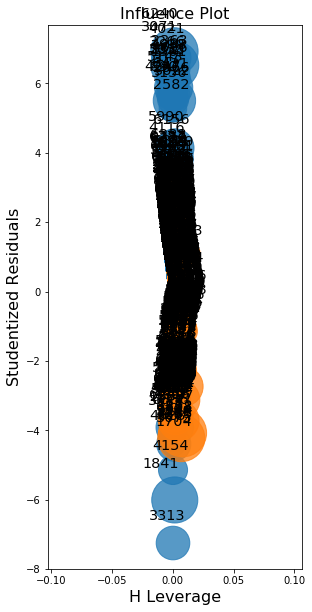

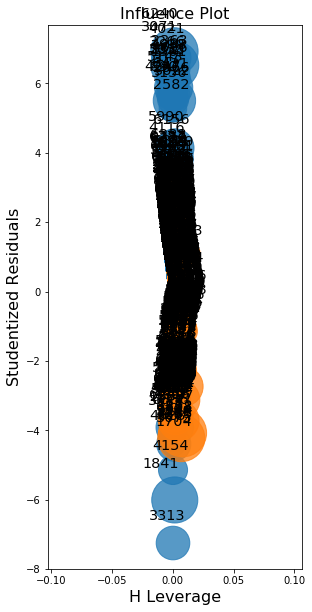

In [49]:
# statsmodels influence plot
fig = pl.figure(figsize=(10,10))
ax = fig.add_subplot(121)
sm.graphics.influence_plot(model_r, criterion='cooks', ax=ax)
sm.graphics.influence_plot(model_w, criterion='cooks', ax=ax)

Figure 13: Two influence plots of energy and units. These plots show the influence observations have on the predictive power of our models and the size of their residuals. The top model's most influential observations are also the ones with the highest residual error. For the bottom model, the most influential observations have the lowest residual error.

# Comparing the linear and curve fit with Likelihood Ratio LR test; we require a significance $\alpha=0.05$

** The curve fit and linear fit od the Energy vs Units can be compared with LR test because they are nested models**

** The difference in the number of degrees of freedom is 1, so the LR statistics will follow a $\chi^2$ distribution with 1 DOF.**



In [50]:
alpha = 0.05
lratio = model_best.compare_lr_test(model_r)
print('Likelihood ratio: ', lratio)

Likelihood ratio:  (755.0854517493035, 3.1451851219055871e-166, 1.0)


We compare the likelihood ratio of 755 to 3.84, the critical value at alpha=.05 in the chi square table. Since the ratio is much larger/far to the right of 3.84, we reject the null hypothesis that the restricted/less complex model is better than the polynomial model. 